In [1]:
import glob
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from matplotlib import animation
from scipy.interpolate import Rbf
import pandas as pd
import numba as nb


# Read the data and variables From Full dataset

In [2]:
path2016 = "data/jason3/2016/*.nc/*.nc"
path2017 = "data/jason3/2017/*.nc/*.nc"
path2018 = "data/jason3/2018/*.nc/*.nc"
path2019 = "data/jason3/2019/*.nc/*.nc"
path2020 = "data/jason3/2020/*.nc/*.nc"
path2021 = "data/jason3/2021/*.nc/*.nc"

#outputFile = "reduced_caspian_2018.csv"

files = glob.glob(path2020)
ncid = []

for i, file in enumerate(files):
    ncid.append(nc.Dataset(file))


In [4]:
print(ncid[100].Conventions)

CF-1.1


In [17]:
def read_1_1variable_data(ncid, varname):
    var = None
    try:
        var = ncid.variables[varname]
    except KeyError as e:
        print("KeyError" + str(e), len(row), ncid.variables)
    return var

def read_1_7variable_data(ncid, varname):
    var = None
    try:
        if "range_ocean" in varname or "ssha" in varname:
             var = ncid.groups["data_01"].groups["ku"].variables[varname]
        else:
             var = ncid.groups["data_01"].variables[varname]                    
    except KeyError as e:
        print("KeyError" + str(e), len(var), ncid.variables)
    return var

def read_pass_number(ncid, convention="1.1", varname="lat"):
    row = []
    try:
        if "1.1" in convention:
            ncid.variables[varname]
            row.append(ncid.pass_number)

        else:
            row.append(ncid.pass_number)

    except KeyError as e:
        print("Read pass number error: ", e, len(row), x)
        return row
    return row

## Optimized numpy attempt

In [19]:
# Read variable Data CF-1.1 Convention
latList = []
lonList = []
meanSeaSurfaceList  = []
timeList = []
surfaceTypeList = []
rangeList = []
sshaList = []
altitudeList = []
bathymetryList = []
geoflagsList = []
qualityFlagList = []
passNumberList = []


for x in range(len(ncid)):
    if "CF-1.1" in ncid[x].Conventions:     
        latList.append(read_1_1variable_data(ncid[x], "lat"))
        lonList.append(read_1_1variable_data(ncid[x], "lon"))
        meanSeaSurfaceList.append(read_1_1variable_data(ncid[x], "mean_sea_surface"))
        timeList.append(read_1_1variable_data(ncid[x], "time"))
        surfaceTypeList.append(read_1_1variable_data(ncid[x], "surface_type"))
        rangeList.append(read_1_1variable_data(ncid[x], "range_ku"))
        sshaList.append(read_1_1variable_data(ncid[x], "ssha"))
        altitudeList.append(read_1_1variable_data(ncid[x], "alt"))
        bathymetryList.append(read_1_1variable_data(ncid[x], "bathymetry"))
        geoflagsList.append(read_1_1variable_data(ncid[x], "geophysical_quality_flag"))
        qualityFlagList.append(read_1_1variable_data(ncid[x], "alt_quality_flag"))
        passNumberList.append(read_pass_number(ncid[x]))
    else:
        latList.append(read_1_7variable_data(ncid[x], "latitude"))
        lonList.append(read_1_7variable_data(ncid[x], "longitude"))
        meanSeaSurfaceList.append(read_1_7variable_data(ncid[x], "mean_sea_surface_cnescls"))
        timeList.append(read_1_7variable_data(ncid[x], "time"))
        surfaceTypeList.append(read_1_7variable_data(ncid[x], "surface_classification_flag"))
        rangeList.append(read_1_7variable_data(ncid[x], "range_ocean"))
        sshaList.append(read_1_7variable_data(ncid[x], "ssha"))
        altitudeList.append(read_1_7variable_data(ncid[x], "altitude"))
        bathymetryList.append(read_1_7variable_data(ncid[x], "depth_or_elevation"))
        geoflagsList.append(read_1_7variable_data(ncid[x], "geo_qual"))
        qualityFlagList.append(read_1_7variable_data(ncid[x], "alt_qual"))
        passNumberList.append(read_pass_number(ncid[x], "1.7"))
        
dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 15000
print(height, width, len(dataLists[0]))


8 15000 4257


In [9]:
# Read variable Data CF-1.7 Convention

latList = read_variable_data(ncid, "latitude")
lonList = read_variable_data(ncid, "longitude")

meanSeaSurfaceList = read_variable_data(ncid, "mean_sea_surface_cnescls")
timeList = read_variable_data(ncid, "time")
surfaceTypeList = read_variable_data(ncid, "surface_classification_flag")
rangeList = read_variable_data(ncid, "range_ocean")
sshaList = read_variable_data(ncid, "ssha")
altitudeList = read_variable_data(ncid, "altitude")

bathymetryList = read_variable_data(ncid, "depth_or_elevation")
geoflagsList = read_variable_data(ncid, "geo_qual")
#qualityFlagList = read_variable_data(ncid, "alt_qual")
passNumberList = read_pass_number(ncid, convention="1.7", varname="latitude")

dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 14500
print(height, width, len(dataLists[0]))

8 14500 4347


In [22]:
def pad(arr):
    if width - len(arr) < 0:
        print(len(arr))
    return np.pad(arr, (0, width - len(arr)), mode='constant',constant_values=(np.nan,))

vectors = []
orbitPassesMat = np.full([len(dataLists[0]), width, ], np.nan)


for i, data in enumerate(dataLists):
    print("data type: {}, {} of {}".format(dataListsNames[i], i + 1, len(dataLists)))
    tempMat = np.full([len(data), width, ], np.nan)
    for x in range(len(data)):
        # should cover reading pass number list as this is not a nested list. Otherwise read nested using x as index        
        if (i == 0):
            orbitPass = passNumberList[x]
            orbitPassesMat[x,:] = orbitPass
            
        arr = np.array(data[x])
         #   len(data[x])
        #except:
            #
        
        arr = arr.astype(np.float32)
        entries = pad(arr)
        tempMat[x,:] = entries
    
    tempVector = tempMat.flatten()
    vectors.append(tempVector)
    
    if ( i == len(dataLists) - 1):
        orbitPasses = orbitPassesMat.flatten()
        vectors.append(orbitPasses)

data type: lat, 1 of 8
data type: lon, 2 of 8
data type: time, 3 of 8
data type: mss, 4 of 8
data type: surface type, 5 of 8
data type: range, 6 of 8
data type: altitude, 7 of 8
data type: geophysical quality flag, 8 of 8


In [24]:
# Rotate matrix and convert to pandas dataframe
dataMat = np.array(vectors)
print(dataMat.shape)
dataMat = np.transpose(dataMat)

print(dataMat.shape)

df = pd.DataFrame(dataMat)
df.columns = dataListsNames

(9, 63855000)
(63855000, 9)


In [25]:
df = df.drop(df[(df.lon > lonMax)].index)
df = df.drop(df[(df.lon < lonMin)].index)



In [26]:
df = df.drop(df[(df.lat > latMax)].index)
df = df.drop(df[(df.lat < latMin)].index)

In [27]:
df = df.dropna()

In [28]:

df["day"] = ""
df["month"] = ""
df["year"] = ""

base_date = datetime(2000, 1, 1)
print("Day")
df["day"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).day)
print("Month")
df["month"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).month)
print("Year")
df["year"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).year)


Day
Month
Year


In [29]:
df.head(100)

,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year
180803,47.969185,47.887955,631237120.0,-10.8362,3.0,2.147484e+09,1349423.375,127.0,167.0,1,1,2020
180804,47.925907,47.932610,631237120.0,-10.8899,3.0,1.349427e+06,1349409.750,127.0,167.0,1,1,2020
180805,47.882607,47.977180,631237120.0,-10.8655,3.0,2.147484e+09,1349396.125,127.0,167.0,1,1,2020
180806,47.839287,48.021667,631237120.0,-10.8325,3.0,2.147484e+09,1349382.500,127.0,167.0,1,1,2020
180807,47.795944,48.066078,631237120.0,-10.8018,3.0,2.147484e+09,1349369.000,127.0,167.0,1,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
180898,43.786331,51.782925,631237184.0,-11.3925,3.0,2.147484e+09,1348107.125,127.0,167.0,1,1,2020
180899,43.741318,51.820770,631237184.0,-11.4528,3.0,2.147484e+09,1348093.000,127.0,167.0,1,1,2020
180900,43.696281,51.858555,631237184.0,-11.4517,3.0,2.147484e+09,1348078.875,127.0,167.0,1,1,2020
180901,43.651234,51.896275,631237184.0,-11.4650,3.0,2.147484e+09,1348064.750,127.0,167.0,1,1,2020


In [33]:
df.to_csv(r'reduced_caspian_2020.csv', index=False)


In [30]:
data = df.loc[(df.month == 12) &(df.year == 2016) & (df["surface type"] == 1)]
data.head(10000)


,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year


[ 91. 105. 132. 167. 208. 233. 243.  15.  29.  56. 107. 234.  65. 106.
 207.]


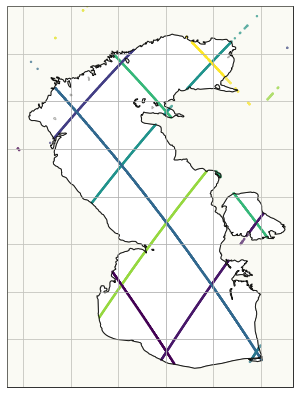

In [32]:
import cartopy.crs as crs
import cartopy.feature as feat

def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

data = df.loc[(df.month == 12) & (df["surface type"] == 2)]


fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

print(data["pass number"].unique())
